In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
%matplotlib inline

In [3]:
import rankingmethod
import rankingmeasure

In [4]:
%load_ext autoreload
%autoreload 2

In [110]:
from  experiment import *

In [58]:
respath = 'rresults/s/'

# loading data sets

In [31]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [32]:
epinion, epinion_shape = make_valid_data(data)

In [33]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [34]:
slashdot, slashdot_shape = make_valid_data(data)

In [79]:
data =  pd.read_csv("../datasets/ml-100k/u.data", sep='\t', header=None).ix[:, :1]
data = data.as_matrix()

In [80]:
ml100k, ml100k_shape = make_valid_data(data)

In [104]:
data = pd.read_csv("../datasets/ml-1m/ratings.dat", sep='::', header=None,  engine='python').ix[:, :1]
data = data.as_matrix()

In [105]:
ml1m, ml1m_shape = make_valid_data(data)

### Зададим параметры, которые были выбраны при помощи валидации

In [37]:
def create_list_cf(user_item):
    list_cf = [
        rankingmethod.PopRec(user_item),
        rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
        rankingmethod.BPR_MF(user_item, K = 20, lrate=0.012, regIpos=0.012, 
                                  regIneg=0.012, regU=0.012, maxiter=4, verbose=0 ),
        rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
        rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=10)   
    ]
    return list_cf

### Проведение такого же эксперимента, как у создатей CLiMF(Точнее похожего, т.к. было решено не удалять топ 3 всех предметов. И даже с этим удалением получить такие же цифры, что авторы epinion не получилось)

In [55]:
def climf_experiment(data, list_cf, K=5, maxiter=1, topK=5, verbose=0):
    res = np.zeros((6, len(list_cf)))
    for t in range(maxiter):
        train, test, traintest = givenK_train_test(data, K)
        for i, cf in enumerate(list_cf):
            cf.fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, cf, K=topK)
            mrr, auc = rankingmeasure.get_listmetrics(train, test, cf)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp, mrr, auc])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
    res /= maxiter
    res = pd.DataFrame(res)
    res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP']
    res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
               'MAP@' + str(topK), 'MRR', 'AUC']
    return res

In [56]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =5, maxiter=1, topK=5,  verbose=1)

0 0 [ 0.19441544  0.5738933   0.22191584  0.3956946   0.44729325  0.83140426]
0 1 [ 0.19586833  0.57116913  0.22168011  0.39170293  0.44774633  0.74961251]
0 2 [ 0.19509648  0.57570942  0.22223038  0.395641    0.44722935  0.83441822]
0 3 [ 0.18102157  0.53620885  0.19383637  0.33370066  0.3824311   0.69397896]
0 4 [ 0.18288309  0.56027242  0.21205831  0.39143272  0.44094471  0.64683492]


In [ ]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =10, maxiter=1, topK=5,  verbose=1)

In [60]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K =5, maxiter=1, topK=5,  verbose=0)

0 0 [ 0.12251144  0.37657323  0.1319391   0.22953991  0.27654298  0.77703793]
0 1 [ 0.12274027  0.37743135  0.13169759  0.22891141  0.27554472  0.68970927]
0 2 [ 0.12105263  0.37614416  0.1309013   0.22970379  0.27613604  0.78503591]
0 3 [ 0.10494851  0.34196224  0.10975562  0.1949623   0.23434489  0.59086203]
0 4 [ 0.11538902  0.35926773  0.12445819  0.21948119  0.25677406  0.59737827]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.122511,0.122740,0.121053,0.104949,0.115389
1recal@5,0.376573,0.377431,0.376144,0.341962,0.359268
NDCG@5,0.131939,0.131698,0.130901,0.109756,0.124458
MAP@5,0.229540,0.228911,0.229704,0.194962,0.219481
MRR,0.276543,0.275545,0.276136,0.234345,0.256774
AUC,0.777038,0.689709,0.785036,0.590862,0.597378


In [61]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K=10, maxiter=1, topK=5,  verbose=0)

0 0 [ 0.11192792  0.35283181  0.12102636  0.2146759   0.26020113  0.81278055]
0 1 [ 0.11189931  0.35283181  0.12100122  0.21473311  0.2598129   0.75821488]
0 2 [ 0.11284325  0.35311785  0.1207925   0.21107714  0.25587895  0.81823682]
0 3 [ 0.13584096  0.39287757  0.1424579   0.23748272  0.27949474  0.69255127]
0 4 [ 0.11281465  0.35440503  0.121591    0.21485865  0.25942938  0.66626014]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.111928,0.111899,0.112843,0.135841,0.112815
1recal@5,0.352832,0.352832,0.353118,0.392878,0.354405
NDCG@5,0.121026,0.121001,0.120793,0.142458,0.121591
MAP@5,0.214676,0.214733,0.211077,0.237483,0.214859
MRR,0.260201,0.259813,0.255879,0.279495,0.259429
AUC,0.812781,0.758215,0.818237,0.692551,0.666260


In [76]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=5, maxiter=5, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.530918,0.513151,0.530323,0.462531,0.262481
1recal@5,0.943176,0.933499,0.937469,0.897022,0.746154
NDCG@5,0.534166,0.517198,0.531936,0.475641,0.305572
MAP@5,0.670363,0.651275,0.663692,0.634136,0.545234
MRR,0.704501,0.697036,0.701981,0.681804,0.593101
AUC,0.827417,0.757246,0.828865,0.678551,0.636698


In [108]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=10, maxiter=5, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.513499,0.509628,0.505211,0.517469,0.442581
1recal@5,0.922581,0.918114,0.922084,0.923325,0.885608
NDCG@5,0.507787,0.504557,0.503772,0.530995,0.452206
MAP@5,0.635181,0.636478,0.639301,0.678191,0.609859
MRR,0.663062,0.661163,0.666583,0.727297,0.655431
AUC,0.846221,0.818456,0.846638,0.777433,0.721385


In [109]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=15, maxiter=5, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.484119,0.482184,0.473846,0.530720,0.473846
1recal@5,0.914640,0.914144,0.907444,0.929280,0.893797
NDCG@5,0.493463,0.495831,0.472595,0.536979,0.480281
MAP@5,0.649267,0.656846,0.611769,0.674191,0.621278
MRR,0.688521,0.698497,0.647435,0.713904,0.666023
AUC,0.853098,0.840584,0.853146,0.828562,0.763474


In [111]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=5, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.480555,0.483583,0.479762,0.473995,0.413840
1recal@5,0.880519,0.870427,0.882682,0.870788,0.853848
NDCG@5,0.493571,0.495208,0.492313,0.485062,0.451584
MAP@5,0.648909,0.653467,0.648408,0.628551,0.662639
MRR,0.694116,0.691678,0.693038,0.672882,0.701911
AUC,0.850340,0.828613,0.848813,0.718570,0.747666


In [107]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=10, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.490395,0.490395,0.483583,0.573905,0.490611
1recal@5,0.861056,0.861056,0.847901,0.930258,0.858713
NDCG@5,0.501165,0.501165,0.491860,0.583821,0.501419
MAP@5,0.655779,0.655779,0.615115,0.708827,0.659461
MRR,0.690318,0.690345,0.659755,0.753014,0.689735
AUC,0.856129,0.851473,0.855643,0.827976,0.804301


In [ ]:
for i in range(5, 16, 5):
    res = climf_experiment(epinion, create_list_cf(epinion_shape), K = i, topK=5)
    with open( respath + '_climfexperiment_' + 'epinion' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    print(res)
    sys.stdout.flush()

In [ ]:
for i in range(5, 16, 5):
    res = climf_experiment(slashdot, create_list_cf(slashdot_shape),K = i, topK=5)
    with open( respath + '_climfexperiment_' + 'slashdot' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    print(res)
    sys.stdout.flush()

In [ ]:
# for i in range(5, 21, 5):
#     with open('climf_res' + str(i) +'.pickle', 'rb') as f:
#         tbl = pickle.load(f)
#     print('---------')
#     print('K =', i)
#     show_smart_table(tbl)
#     with open('climf_res_top' + str(i) + '.pickle', 'rb') as f:
#         tbl = pickle.load(f)
#     print('---------')
#     print('K =', i, 'without top')
#     show_smart_table(tbl)

### Сравнение работы методов(на наборе данных epinion). В данный момент мне кажется, что данныйэксперимент не совсем коректен

In [ ]:
import rankensemble

In [57]:
ens = rankensemble.ensemble(list_cf, verbose=1)

In [ ]:
train, test, traintest = givenK_train_test(data, 5)

In [58]:
ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [88]:
mean_matrix_similar(ens, topK=5)

array([[ 0.        ,  0.80068104,  0.99350738,  0.15718502,  0.96286039],
       [ 0.80068104,  0.        ,  0.80485812,  0.15582293,  0.80190692],
       [ 0.99350738,  0.80485812,  0.        ,  0.15741203,  0.95750284],
       [ 0.15718502,  0.15582293,  0.15741203,  0.        ,  0.15723042],
       [ 0.96286039,  0.80190692,  0.95750284,  0.15723042,  0.        ]])

In [89]:
mean_matrix_similar(ens, topK=10)

array([[ 0.        ,  0.90338252,  0.99920545,  0.18208854,  0.64785471],
       [ 0.90338252,  0.        ,  0.9030874 ,  0.18256527,  0.67334847],
       [ 0.99920545,  0.9030874 ,  0.        ,  0.18213394,  0.64735528],
       [ 0.18208854,  0.18256527,  0.18213394,  0.        ,  0.17053348],
       [ 0.64785471,  0.67334847,  0.64735528,  0.17053348,  0.        ]])

### Построение ансамбля

In [118]:
import rankensemble

In [156]:
def ensemble_experiment(data, list_cf, list_ensemble, K=5, maxiter=1, topK=5, verbose=0):
    res = np.zeros((4, len(list_cf) + len(list_ensemble)))
    for t in range(maxiter):
        train, test, traintest = givenK_train_test(data, K)
        for i in range(len(list_cf)):
            list_cf[i].fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, list_cf[i], K=topK)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
            
        for j, ens in enumerate(list_ensemble):
            m = j + len(list_cf)
            ens.fit(list_cf)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, ens, K=topK)
            res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, m, res[:, m] / (t +1))
        
    res /= maxiter
    res = pd.DataFrame(res)
    res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP', 'top_ensemble', 'rating_ensamble']
    res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
               'MAP@' + str(topK)]
    return res

In [126]:
list_ensemble = [
    rankensemble.top_ensemble(topK=100),
    rankensemble.rating_ensemble()
]

In [157]:
ensemble_experiment(ml100k, create_list_cf(ml100k_shape), list_ensemble, K=5, maxiter=1, topK=5, verbose=1)

0 0 [ 0.54168734  0.9516129   0.56554854  0.73091915]
0 1 [ 0.53523573  0.94789082  0.56062876  0.72182417]
0 2 [ 0.53002481  0.94665012  0.54791251  0.71001344]
0 3 [ 0.47047146  0.9057072   0.48534118  0.64311759]
0 4 [ 0.28684864  0.80645161  0.35644954  0.6578698 ]
0 5 [ 0.49181141  0.94665012  0.52469951  0.71084746]
0 6 [ 0.51960298  0.95409429  0.55077109  0.73050041]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.541687,0.535236,0.530025,0.470471,0.286849,0.491811,0.519603
1recal@5,0.951613,0.947891,0.946650,0.905707,0.806452,0.946650,0.954094
NDCG@5,0.565549,0.560629,0.547913,0.485341,0.356450,0.524700,0.550771
MAP@5,0.730919,0.721824,0.710013,0.643118,0.657870,0.710847,0.730500


In [162]:
ensemble_experiment(ml100k, create_list_cf(ml100k_shape), list_ensemble, K=5, maxiter=5, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.531216,0.494541,0.530174,0.473449,0.175831,0.424814,0.471861
1recal@5,0.937717,0.933251,0.936973,0.900744,0.595037,0.892308,0.920596
NDCG@5,0.529777,0.504456,0.528797,0.487309,0.205168,0.437663,0.486816
MAP@5,0.661718,0.658123,0.663150,0.642809,0.400903,0.602600,0.651020


In [134]:
ensemble_experiment(epinion, create_list_cf(epinion_shape), list_ensemble, K=5, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.200772,0.200817,0.200863,0.185108,0.173984,0.208445,0.208808
1recal@5,0.567537,0.567764,0.567991,0.547333,0.535074,0.607037,0.602951
NDCG@5,0.226087,0.225243,0.226201,0.194972,0.192173,0.229174,0.232720
MAP@5,0.393387,0.390337,0.393568,0.330410,0.345052,0.397119,0.403010


In [133]:
ensemble_experiment(epinion, create_list_cf(epinion_shape), list_ensemble, K=10, maxiter=1, topK=5, verbose=0)

0 0 [ 0.18342792  0.51509648  0.20601151  0.3564737 ]
0 1 [ 0.18410897  0.51577753  0.20671154  0.35824001]
0 2 [ 0.18270148  0.51055619  0.20579179  0.35790989]
0 3 [ 0.25357548  0.63813848  0.2618443   0.39858147]
0 4 [ 0.17934166  0.5107832   0.20290152  0.3545671 ]
0 5 [ 0.22860386  0.62860386  0.24676022  0.40783485]
0 6 [ 0.21262202  0.60090806  0.22739217  0.3751586 ]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.183428,0.184109,0.182701,0.253575,0.179342,0.228604,0.212622
1recal@5,0.515096,0.515778,0.510556,0.638138,0.510783,0.628604,0.600908
NDCG@5,0.206012,0.206712,0.205792,0.261844,0.202902,0.246760,0.227392
MAP@5,0.356474,0.358240,0.357910,0.398581,0.354567,0.407835,0.375159


In [136]:
np.random.choice(5, 5, replace=False)

array([1, 4, 0, 3, 2])

In [150]:
import random
a = [1,2,3,4,5]
print(random.shuffle(a), a)

None [5, 1, 3, 2, 4]


## Старые не  красивые эксперименты

### проверка работы ансамбля givenk = 5

In [34]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.20889898,  0.59659478,  0.23334799,  0.40400019])

In [36]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.19704881  0.55913734  0.22254752  0.38464813]
[ 0.1938252   0.56118048  0.22009766  0.38748802]
[ 0.19523269  0.56072645  0.22107609  0.38591121]
[ 0.17711691  0.52485812  0.18861426  0.32164586]
[ 0.18719637  0.55323496  0.21465356  0.38445958]


In [37]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 10)

array([ 0.17402951,  0.72122588,  0.20026969,  0.37375175])

In [38]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 10))

[ 0.16944381  0.68876277  0.19412473  0.35670129]
[ 0.16989784  0.68944381  0.19419015  0.3561263 ]
[ 0.16955732  0.69057889  0.19406199  0.35569465]
[ 0.15768445  0.67309875  0.17098093  0.31099781]
[ 0.15738933  0.65788876  0.18414103  0.35370021]


### проверка работы ансамбля givenk = 10 iMF слишком хорошо работает(

In [59]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.24281498,  0.676958  ,  0.26581623,  0.44658374])

In [60]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.18320091  0.53416572  0.20701312  0.36450404]
[ 0.1815664   0.53870602  0.20560403  0.36648253]
[ 0.18292849  0.53348468  0.20675077  0.36393303]
[ 0.26115778  0.71577753  0.28306775  0.47061798]
[ 0.17257662  0.51577753  0.19827725  0.35810853]


In [44]:
import time
t = time.time()
a = top_ens.get_list(0, 4000)
print(time.time() - t)

0.31627511978149414


In [97]:
a =np.arange(6*3).reshape(6, 3)
print(a)
print(a.ravel())
print(a.T.ravel())

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  3  6  9 12 15  1  4  7 10 13 16  2  5  8 11 14 17]


In [57]:
ansamble.show_all_ulist(5, 10)

PopRec [  18  721 1042  674  143  118  711  136   34 1536]
CLiMF [  18  674  721 1042 1536  118  143  711  136   34]
BPR_MF [  18 1042  721  674  143  118 1536  136   34  711]
iMF [497 362 378  43   1 379  10  12  79 125]
TFMAP [  18  674 1042  721  711   28  143 3805   34   77]


In [119]:
import copy
import sys
class rating_ensemble:
    def __init__(self, list_cf, weights = None, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        if weights is None:
            self.weights = np.ones(len(list_cf))/len(list_cf)
        else:
            assert(weights.shape[0] == len(list_cf))
            self.weights = weights
        self.N_items = self.list_cf[1].N_items
        self.N_methods = len(self.list_cf)
        #self.index = np.arange(self.N_items)[::-1] + 1
        self.index = np.exp(-0.5 * np.arange(self.N_items))
        
    def get_list(self, u):
        res = np.zeros(self.N_items)
        for i in range(self.N_methods):
            ranks = self.list_cf[i].get_list(u)
            res[ranks] += self.weights[i] * self.index 
        return np.argsort(-res)
    

### givenK = 5

In [95]:
train5, test5, traintest5 = givenK_train_test(epinion, 5)

In [97]:
ens5 = ensemble(list_cf, verbose=1)
ens5.fit(train5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [98]:
rating_ens = rating_ensemble(ens5.list_cf)

In [102]:
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20340522,  0.57207719,  0.21539089,  0.35614769])

In [103]:
for cf in rating_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train5, test5, cf, True, K = 5))

[ 0.19723042  0.5523269   0.22281641  0.38555146]
[ 0.19673099  0.55005675  0.22215417  0.38491046]
[ 0.1953689   0.55005675  0.22130483  0.38498266]
[ 0.17734393  0.53461975  0.18653377  0.31993852]
[ 0.18696935  0.54801362  0.21227095  0.37798714]


In [120]:
rating_ens = rating_ensemble(ens5.list_cf)
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20281498,  0.57707151,  0.22675051,  0.39048966])

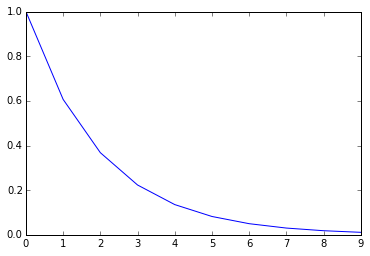

In [117]:
plt.plot(np.exp(-0.5 * np.arange(10)))

In [64]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

In [65]:
a

array([4, 4, 2, 2, 8, 7, 1, 2, 0, 6])

In [67]:
np.argsort(-a)

array([4, 5, 9, 0, 1, 2, 3, 7, 6, 8])

In [ ]:
np.argosrt()

In [61]:
a = None

In [63]:
if a is None:
    print("ywe")

ywe


# Slashdot data set

In [127]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [128]:
data.shape

(905467, 2)

In [129]:
slashdot, user_item = make_valid_data(data)

In [155]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, reg=0.001, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [132]:
train, test, traintest = givenK_train_test(slashdot, 5)

In [133]:
poprec = rankingmethod.PopRec(user_item_slash)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.122225400458
1-call5 0.37528604118993136
MRR 0.273406086512
AUC 0.776325504811
NGDC 0.131158605935
MAP 0.227184043669


### givenk = 5

In [138]:
slash_ens = ensemble(list_cf, verbose=1)

In [139]:
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [140]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.1222254   0.37528604  0.13115861  0.22718404]
[ 0.12233982  0.37585812  0.13122573  0.22734037]
[ 0.12268307  0.37585812  0.1314579   0.227249  ]
[ 0.10420481  0.33495423  0.10975777  0.19563589]
[ 0.12062357  0.37628719  0.12923841  0.22546283]


In [141]:
top_ens = top_ensemble(slash_ens.list_cf, topK=100)

In [142]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.12402746,  0.39487986,  0.13112244,  0.23042843])

### givenk = 10

In [156]:
train, test, traintest = givenK_train_test(slashdot, 10)

In [157]:
slash_ens = ensemble(list_cf, verbose=1)
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [158]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
#all_measures(train, test, poprec, True, top)
rankingmeasure.get_Kmetrics(train, test, poprec, True, K=5)

array([ 0.10918192,  0.3506865 ,  0.11928689,  0.21512741])

In [159]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10943936  0.35054348  0.11506516  0.2026143 ]
[ 0.13667048  0.40789474  0.14297494  0.24199681]
[ 0.10918192  0.3506865   0.11928901  0.21513456]


### Сравнение глазками

In [162]:
for cf in slash_ens.list_cf:
    print(type(cf).__name__)
    print(cf.get_list(0)[:15])

PopRec
[4668  394 2481  225 8848 4690 5043 3443  377  217 5390   34 2470 3444   46]
CLiMF
[4668  394 2481  225 8848 4690 5043 3443  377 5390   34  217 2470   46 2539]
BPR_MF
[ 394 2481 4668  225 8848  217 4690  377 5043 3443   46 5390 2470   34  403]
iMF
[2481 4668  143  151  205   15 4845   59 3369 3947 4979  186  400 5367 3083]
TFMAP
[4668  394 2481  225 8848 4690 5043 3443  377 3444  403  217 5390 5705 7450]


In [150]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.15946796,  0.51001144,  0.16663805,  0.29156159])

# старые эксперименты

In [ ]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

In [ ]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [ ]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [ ]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [ ]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

In [ ]:
rankingmeasure.get_MRR(train, test, climf, True)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
all_measures(train, test, climf, True)

In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)